In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time

import ibdloader
import baseheuristic as bh

rng = np.random.default_rng(2023)

datapath = "../datasets-genotek/"

In [6]:
#dataset 1: 
#only pure population samples and total ibd length and count between them

#CR_graph_rel.csv
#node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
#node_0,node_5,мордвины,мордвины,29.8172,4

#NC_graph_rel.csv 
#node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
#node_0,node_1,чеченцы,чеченцы,9.76537,1
#node_1,node_138,чеченцы,"кабардинцы,черкесы,адыгейцы",8.01344,1

dataset1fname = datapath+"Western-Europe_weights_partial_labels.csv"
#df = pd.read_csv(dataset1fname)
#print(df)

pairs, weights, labels, labeldict, idxtranslator =\
ibdloader.load_pure( dataset1fname, minclassize = 348, removeclasses=['Ashkenazim', 'Russians'] )


#todo    
    #0. filter out populations with less than N individuals
    #1. select 3 best features and add mixed classifier
    #2. distribution of links between in inside classes    
    #2. use other datasets
    #3. apply neuronet
    #4. also need to compose different graphs for different partitions for future training
    #correct simulator

#data struсture conventions:
#node indices in datasets are not necessarily starting from 0 and consecutive 
#so they are enumerated in idxtranslator.
#for every idx the label of node with index idxtranslator[idx] is stored in labels[idx]
#length of both arrays labels and idxtranslator coincides with count of available nodes in the dataset  

#in graphs we store consecutive labels starting from 0
#it can be even subset of idxtranslator, so every graph must have its own gr_idxtranslator
#and possibly gr_labels

#example
#idxtranslator = [0 1 3 5 10]
#       labels = [2 0 2 0 2]
# pairs = [0 10 100]
#         [1 5 100]
#         [3 10 100]
#subset after removing node_3
#idxtranslator = [0 1 5 10]
#       labels = [2 0 0 2]

#lets not produce translated pairs
#just graphs with corresponding edges and nodes from 0 and consecutive


dropping Ashkenazim
dropping Russians
Unique ids in ibd datafile: 6240
Filter out all classes smaller than  348
Removing following classes:
Pashtuns 1
Aymara 1
Korean 1
Egyptians 1
Dagestan 1
Maya 1
Jews-Uzbekistani 1
Karakalpacs 1
Sardinians 1
Jews-Moroccan 1
Siberian-Tatars 1
Sephardim 1
Kosovars 2
Karachays,Balkars 2
Uzbeks 2
Ingush 2
Ossetians 3
Nogais 3
Dolgans,Yakuts 3
Armenians,Hemshins 3
Yanesha 3
Sami 3
Chechens 4
Jews-Azerbaijani 4
Colombians 5
Roma 5
Quechua 5
Mari 6
Azerbaijanis,Iranians,Turks,Yazidis 6
Khanty,Mansi 7
Albanians,Greeks 8
Kabardians,Cherkess,Adygeans 11
Kazakhs 11
Basques 11
Mexicans 11
Mordvins 12
Scots 12
Udmurts,Besermyan 13
Komi 13
Czechs,Slovaks 13
South-Italy 13
Moldovans 13
Estonians 15
Karelians,Veps 22
Spaniards 34
Balkan 39
Tuscans 47
Irish 48
Poles 60
Bashkirs 63
Chuvash 63
Puerto-Ricans 67
Belarusians 107
Ukrainians 111
Danes 132
Lithuanians 148
Swedes 184
Tatars,Volga-Tatars,Mishar-Tatars,Kryashens 243
Norwegians 328
Finns 334
Total 2266 removed


# 1. построим распределение суммарных весов и количества ibd-сегментов

[10.6513   8.51599 11.5081  ...  8.17397  9.03886 47.1837 ]
Distribution of ibd sum
Total values: 21941 min: 8.00007 max: 294.237 ave: 11.457478799963539
filtered values: 21857 min: 8.00007 max: 49.8412 ave: 11.148238786201217


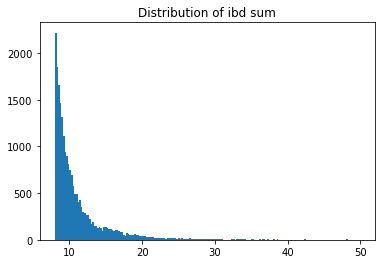

Distribution of ibd max
Total values: 21941 min: 8.00007 max: 58.5241 ave: 10.535790578825031
filtered values: 21936 min: 8.00007 max: 47.0527 ave: 10.52581999407367


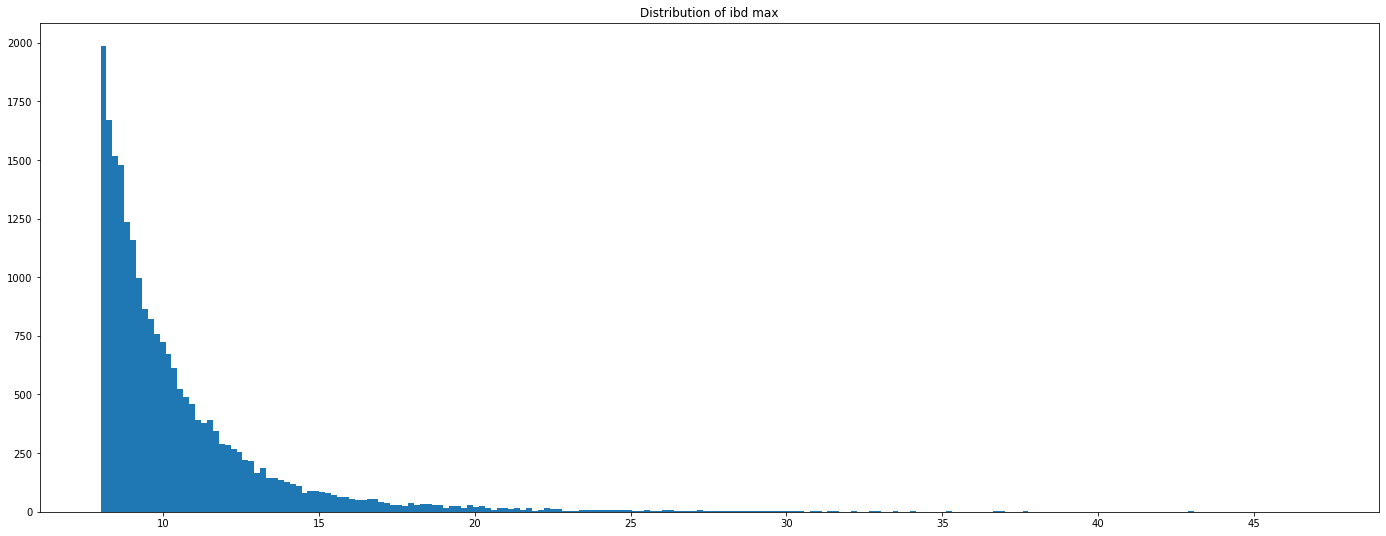

Distribution of ibd count
Total values: 21941 min: 1 max: 17 ave: 1.1051911945672486
filtered values: 21929 min: 1 max: 9 ave: 1.099092525878973


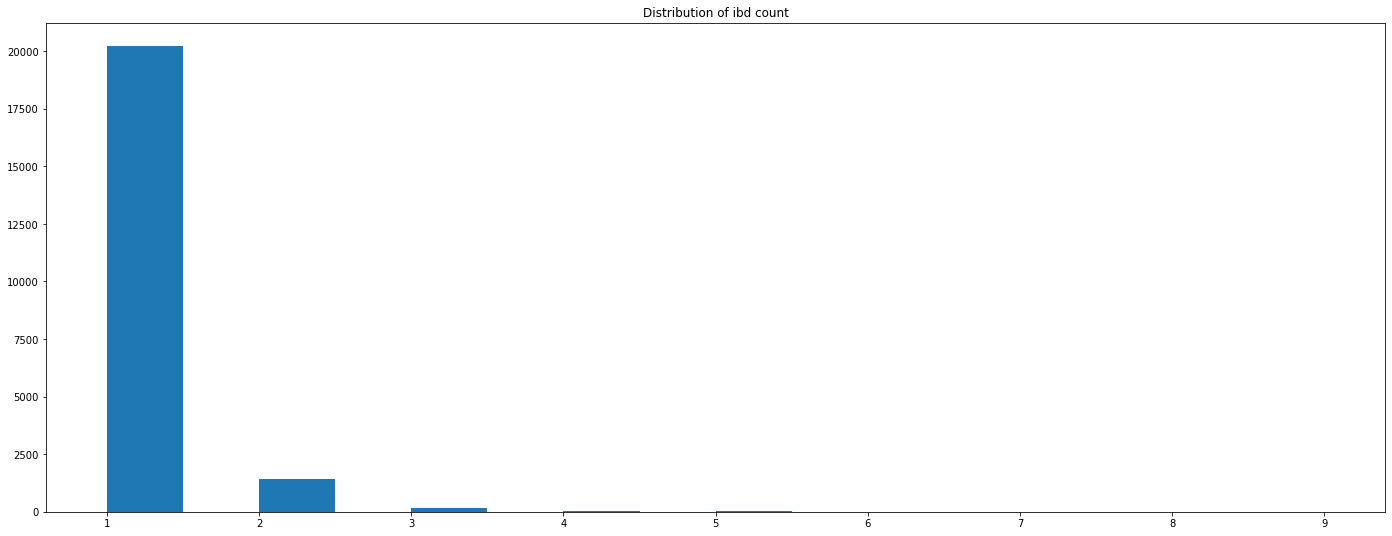

In [7]:
print(weights[:,0])
bh.plot_distribution(weights[:,0], 50, "Distribution of ibd sum")
bh.plot_distribution(weights[:,1], 50, "Distribution of ibd max")
bh.plot_distribution(pairs[:,2], 10, "Distribution of ibd count")

# 2. Распределение весов внутри и между классами

In [8]:
#change plot_distr to true to plot distributions
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
graphdata = bh.composegraphs(pairs, weights, labels, labeldict, idxtranslator)
ncls = graphdata[0]['nodeclasses']
grph = graphdata[0]['graph']
trns = graphdata[0]['translation']

bh.checkpartition(grph, ncls, None, None, details=True, trns=trns)

weimatrix, countmatrix, distrs = bh.getweightandcountmatrices(grph, ncls, labeldict, plot_distr=False)

Partition is ok, no dangling nodes found


In [ ]:
for dst in distrs:
    print(dst)

In [ ]:
#Optional: fit distributions to popular pdf curves
#distributions here are of ibd sum from individual of one class to the whole another class, so they are
#not symmetric, e.g. distribution from mordvins to belarussians is not the same as distribution from belarussians to mordvins

#it is isteresting to see symmetric distribution as well (distribution on ibd-sum of one link between two classes)
#or distribution of link count from individual of one population to the whole another population (also non-symmetrical)

#total distribution of link count between two individuals is not informative (almost constant 1)


#dist_names = ['alpha', 'gamma', 'norm']
dist_names = ['gamma', 'norm']
for label in distrs:
    #label = "южные-русские"
    data = distrs[label]["data"]
    threshold = distrs[label]["threshold"]
    if threshold is None:
        threshold = 1000
    bins = distrs[label]["bins"]
    bh.plot_and_fit_distribution(data, threshold, bins, f"Distribution of ibd sum for {label}", dist_names)

# 3. Матрица сумм весов внутри и между классами

English: 2304
Germans: 750
French: 456
Belgium: 347


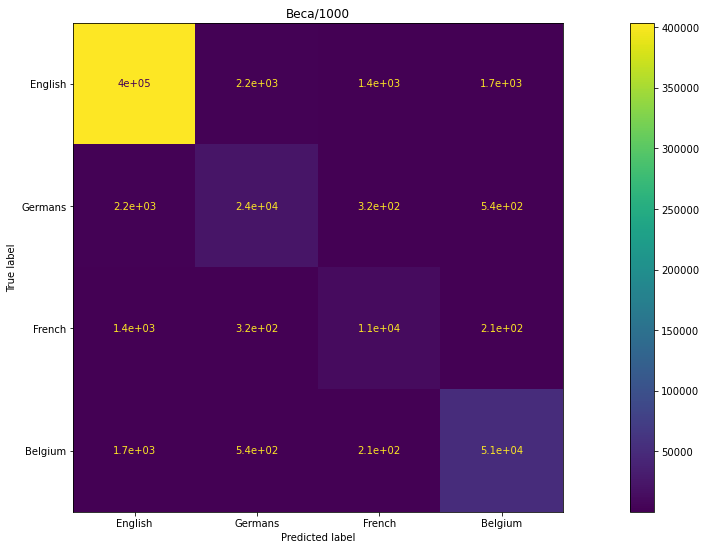

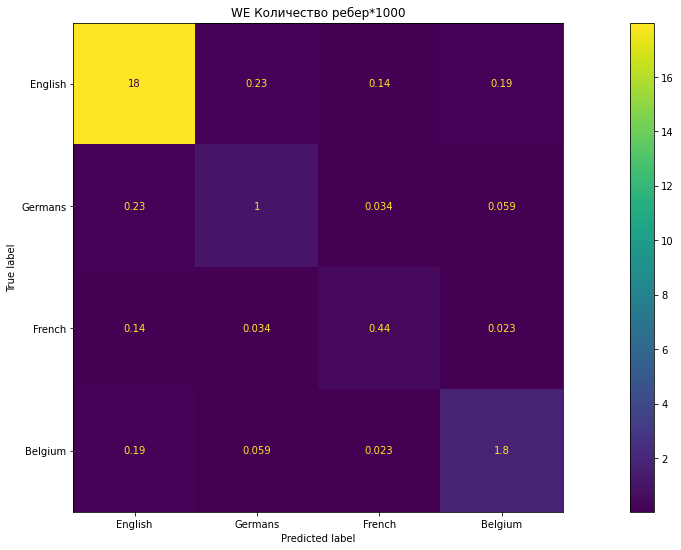

In [10]:
#check total ibd sum between classes
for label in ncls:
    print (f"{label}: {ncls[label].shape[0]}")
    
# в тысячах
cm_display = ConfusionMatrixDisplay(weimatrix, display_labels=labeldict.keys()).plot()
cm_display.ax_.set_title("Веса/1000")
plt.show()
cm_display = ConfusionMatrixDisplay(countmatrix/1000, display_labels=labeldict.keys()).plot()
cm_display.ax_.set_title("WE Количество ребер*1000")
plt.show()

# Классификация

Построим матрицы ошибок по:

1. количеству ребер до известных классов
2. числу ребер на количество членов класса
3. количеству ibd-сегментов до известных классов
4. самому длинный сегмент
5. весу на ребро
6. суммарному весу ребер до известных классов



In [11]:
start = time.time()
featuredict = bh.getfeatures(grph, grph.nodes, ncls, labeldict, pairs, trns )
print(f"features collected in {time.time()-start} seconds\n")

features collected in 3.4273147583007812 seconds



Число ребер до класса: Accuracy: 0.9502, correct: 3665, total: 3857
              precision    recall  f1-score   support

     English       0.94      1.00      0.97      2304
     Germans       0.98      0.89      0.93       750
      French       0.98      0.79      0.87       456
     Belgium       0.94      0.97      0.96       347

    accuracy                           0.95      3857
   macro avg       0.96      0.91      0.93      3857
weighted avg       0.95      0.95      0.95      3857



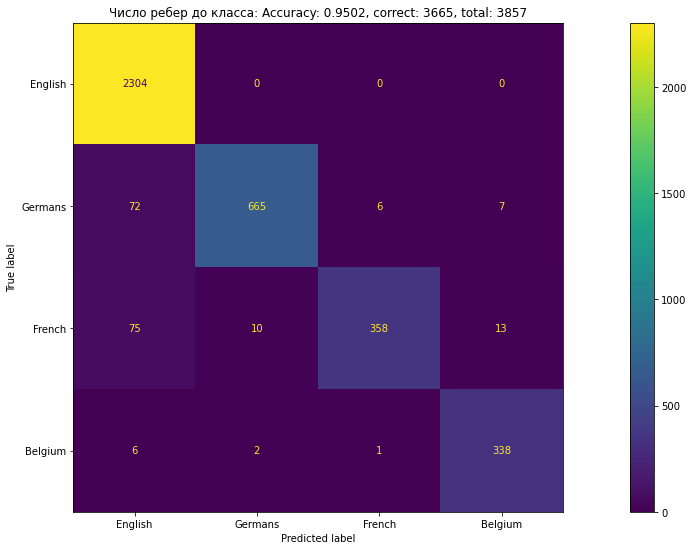

Число ребер до класса на размер класса: Accuracy: 0.9544, correct: 3681, total: 3857
              precision    recall  f1-score   support

     English       0.97      0.98      0.98      2304
     Germans       0.98      0.90      0.94       750
      French       0.95      0.86      0.90       456
     Belgium       0.82      0.99      0.90       347

    accuracy                           0.95      3857
   macro avg       0.93      0.94      0.93      3857
weighted avg       0.96      0.95      0.95      3857



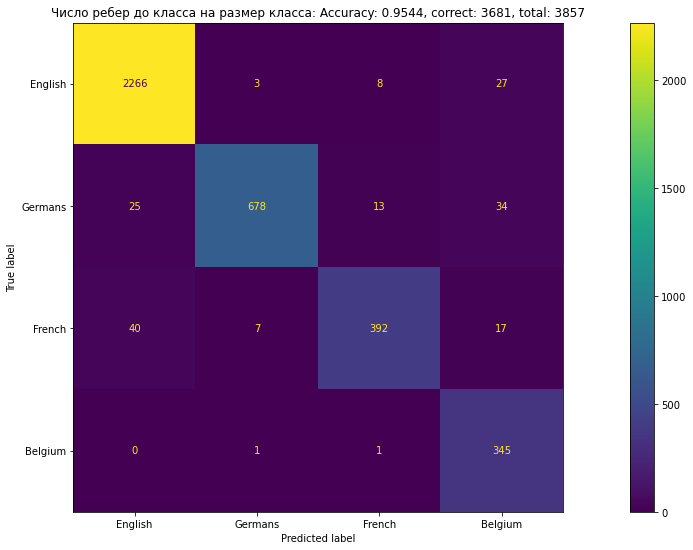

Число ребер до класса с учетом сегментов: Accuracy: 0.9520, correct: 3672, total: 3857
              precision    recall  f1-score   support

     English       0.94      1.00      0.97      2304
     Germans       0.98      0.89      0.93       750
      French       0.98      0.80      0.88       456
     Belgium       0.94      0.98      0.96       347

    accuracy                           0.95      3857
   macro avg       0.96      0.92      0.94      3857
weighted avg       0.95      0.95      0.95      3857



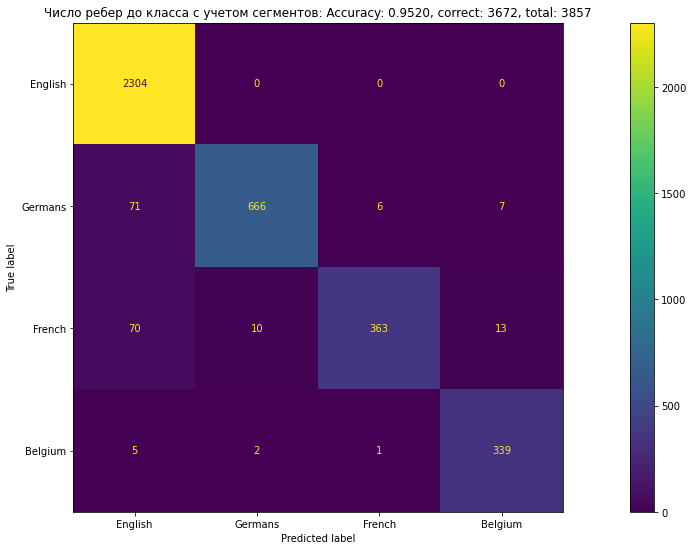

Самый длинный сегмент: Accuracy: 0.9544, correct: 3681, total: 3857
              precision    recall  f1-score   support

     English       0.95      1.00      0.97      2304
     Germans       0.98      0.89      0.93       750
      French       0.97      0.84      0.90       456
     Belgium       0.90      0.97      0.93       347

    accuracy                           0.95      3857
   macro avg       0.95      0.92      0.93      3857
weighted avg       0.96      0.95      0.95      3857



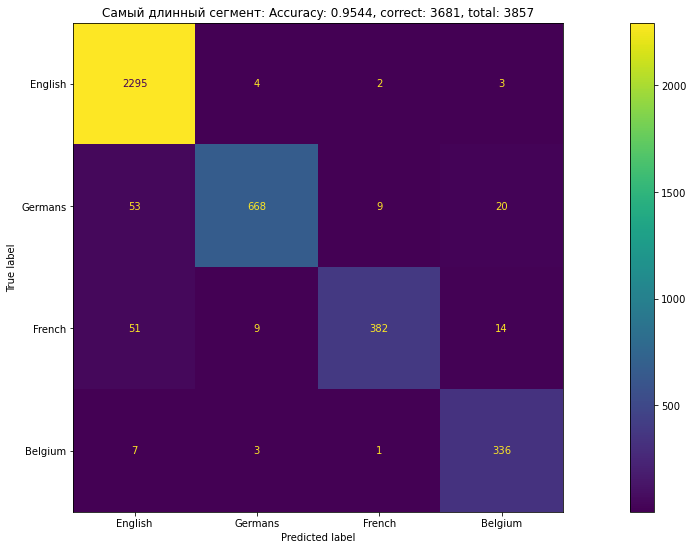

Сумма IBD до класса: Accuracy: 0.9614, correct: 3708, total: 3857
              precision    recall  f1-score   support

     English       0.96      1.00      0.98      2304
     Germans       0.98      0.91      0.95       750
      French       0.98      0.82      0.89       456
     Belgium       0.93      0.99      0.96       347

    accuracy                           0.96      3857
   macro avg       0.96      0.93      0.94      3857
weighted avg       0.96      0.96      0.96      3857



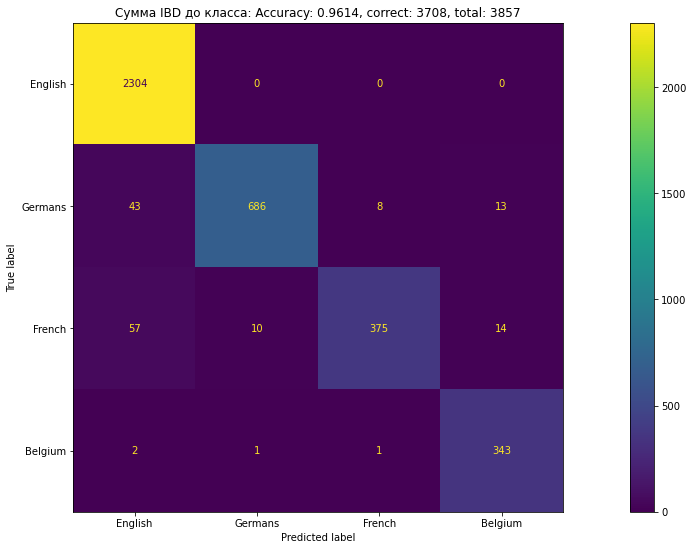

Сумма IBD до класса на ребро: Accuracy: 0.9341, correct: 3603, total: 3857
              precision    recall  f1-score   support

     English       0.95      0.97      0.96      2304
     Germans       0.95      0.88      0.91       750
      French       0.94      0.83      0.88       456
     Belgium       0.84      0.93      0.88       347

    accuracy                           0.93      3857
   macro avg       0.92      0.90      0.91      3857
weighted avg       0.94      0.93      0.93      3857



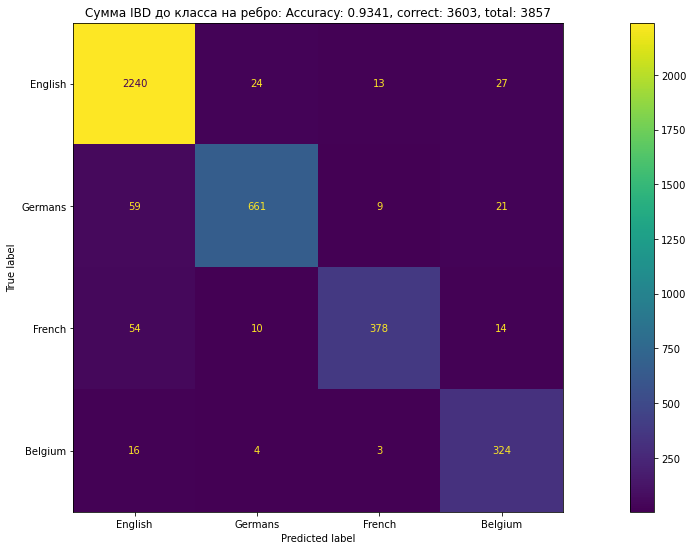

In [12]:
simplepredictions = bh.getsimplepred(featuredict)
for feature in featuredict:
    prediction = simplepredictions[feature]
    title = featuredict[feature]["comment"]
    bh.show_prediction(labels, prediction, labeldict.keys(), title)

# Наиболее уверенный классификатор

In [ ]:
#наиболее уверенный классификатор среди нескольких с весами
#nodecount = labels.shape[0]
#labelcount = len(labeldict)


featureweights = {
    "SegmentCount": 0,
    "SegmentCountPerClassize": 0,
    "SegmentCountWMult": 1,
    "LongestIbd": 1,
    "IbdSum": 1,
    "IbdSumPerEdge": 0
}

#this is useful for the case where no second-best class is available, so several classifiers have infinite confidence
featurepriority = [
    "IbdSum",
    "LongestIbd",
    "SegmentCountWMult",
    "SegmentCountPerClassize",    
    "SegmentCount",    
    "IbdSumPerEdge"]

mostconfident = bh.get_most_confident_prediction(featuredict, featureweights, featurepriority)
bh.show_prediction(labels, mostconfident, labeldict.keys(), "Классификация наиболее уверенным классификатором.")

# Простой перебор для поиска наилучшей комбинации весов

In [ ]:
#search for the best parameter combination
#may take hours
featureweightrange = {
    "SegmentCount": [0],
    "SegmentCountPerClassize": np.arange(0.5,1.5,0.1),
    "SegmentCountWMult": [0],    
    "LongestIbd": [1],
    "IbdSum": np.arange(0.1,1.5,0.1),    
    "IbdSumPerEdge": [0]
}

bestweights, bestaccuracy = bh.search_best_weights(featuredict, featureweightrange, featurepriority, labels, trainnodes = None, show_intermediate = False)
print(bestweights, bestaccuracy)
mostconfident = bh.get_most_confident_prediction(featuredict, bestweights, featurepriority)
bh.show_prediction(labels, mostconfident, labeldict.keys(), "Классификация наиболее уверенным классификатором.")

# Разбиение на "тренировочную", "валидационную" и "тестовую" части

Разделим каждый класс train:val:test = 60:20:20, веса выберем по "тренировочной"+"валидационной" выборке, метрики посчитаем по "тестовой" 

In [6]:
valshare = 0.2
testshare = 0.2
#print(ncls)
#remember that ncls are starting from 0 and consecutive
#also somewhere we should check connectivity, e.g. if test node have connections with train tree at all

permt = bh.getrandompermutation(ncls, rng)
#print(permt)
trainnodeclasses, valnodeclasses, testnodeclasses = bh.dividetrainvaltest(ncls, valshare, testshare, permt)
#here subdivision does not change translation array as we still have the same graph,
#but will compute features only for test nodes and based on links to trainnodeclasses only
trainvalnodeclasses = {}
for c in trainnodeclasses:
    trainvalnodeclasses[c] = np.concatenate((trainnodeclasses[c], valnodeclasses[c]))

print("train|val|test distribution")
for c in trainnodeclasses:
    print(c, ":", trainnodeclasses[c].shape[0], ":", valnodeclasses[c].shape[0], ":", testnodeclasses[c].shape[0])
    #print(c, ":", trainnodeclasses[c], ":", valnodeclasses[c], ":", testnodeclasses[c])


bh.checkpartition(grph, trainnodeclasses, valnodeclasses, testnodeclasses, details=True, trns=trns)

    
trainnodes, valnodes, testnodes = bh.gettrainvaltestnodes(trainnodeclasses, valnodeclasses, testnodeclasses)
print("train nodes:", trainnodes.shape[0])
print("val nodes:", valnodes.shape[0])
print("test nodes:", testnodes.shape[0])

testlabels = labels[testnodes]

start = time.time()
#featuredict = bh.getfeatures(grph, testnodes, trainnodeclasses, labeldict, pairs, trns )
featuredict = bh.getfeatures(grph, grph.nodes, trainvalnodeclasses, labeldict, pairs, trns )
print(f"features collected in {time.time()-start} seconds\n")

simplepredictions = bh.getsimplepred(featuredict)
for feature in featuredict:
    prediction = simplepredictions[feature]
    #predictedlabels = np.array([ prediction[node] for node in testnodes])
    predictedlabels = prediction[testnodes]
    title = featuredict[feature]["comment"]
    bh.show_prediction(testlabels, predictedlabels, labeldict.keys(), title)


train|val|test distribution
Estonians : 22 : 8 : 7
Dolgans,Yakuts : 65 : 22 : 22
Buryats,Hamnigan,Mongols : 29 : 9 : 10
Kazakhs : 66 : 22 : 22
Udmurts,Besermyan : 55 : 18 : 18
Uzbeks : 11 : 4 : 4
Tatars,Volga-Tatars,Mishar-Tatars,Kryashens : 701 : 234 : 234
Ket : 5 : 1 : 2
Mordvins : 40 : 14 : 13
Bashkirs : 290 : 96 : 97
Kabardians,Cherkess,Adygeans : 19 : 6 : 6
Kyrgyz : 19 : 6 : 6
Abkhazians,Georgians,Mingrelians : 7 : 3 : 2
Karelians,Veps : 37 : 12 : 12
Belarusians : 114 : 38 : 38
Ukrainians : 118 : 39 : 39
Chuvash : 200 : 67 : 67
Komi : 25 : 8 : 8
Moldovans : 5 : 2 : 2
Khanty,Mansi : 28 : 10 : 9
Karachays,Balkars : 14 : 5 : 5
Tuvans : 2 : 1 : 1
Nganasan : 2 : 1 : 1
Chelkans,Shors,Tubalar : 6 : 2 : 2
Evenks : 2 : 1 : 1
English : 36 : 12 : 12
Ashkenazim : 107 : 36 : 36
Swedes : 114 : 38 : 38
Balkan : 18 : 6 : 6
Germans : 118 : 39 : 39
Armenians,Hemshins : 13 : 5 : 4
Dagestan : 7 : 2 : 2
French : 8 : 2 : 3
Finns : 510 : 170 : 170
Albanians,Greeks : 4 : 1 : 1
Spaniards : 1 : 0 : 0
Hazar

ValueError: Number of classes, 56, does not match size of target_names, 68. Try specifying the labels parameter

In [13]:
simplepredictions = bh.getsimplepred(featuredict)
for feature in featuredict:
    prediction = simplepredictions[feature]
    #predictedlabels = np.array([ prediction[node] for node in testnodes])
    #в тестовую выборку попали не все классы
    predictedlabels = prediction[testnodes]
    title = featuredict[feature]["comment"]
    print(labeldict)
    print (len(set(testlabels)))
    print (len(set(predictedlabels)))
    print (np.max(testlabels),np.max(predictedlabels), len(labeldict.keys()))
    bh.show_prediction(testlabels, predictedlabels, labeldict.keys(), title)

{'Estonians': 0, 'Dolgans,Yakuts': 1, 'Buryats,Hamnigan,Mongols': 2, 'Kazakhs': 3, 'Udmurts,Besermyan': 4, 'Uzbeks': 5, 'Tatars,Volga-Tatars,Mishar-Tatars,Kryashens': 6, 'Ket': 7, 'Mordvins': 8, 'Bashkirs': 9, 'Kabardians,Cherkess,Adygeans': 10, 'Kyrgyz': 11, 'Abkhazians,Georgians,Mingrelians': 12, 'Karelians,Veps': 13, 'Belarusians': 14, 'Ukrainians': 15, 'Chuvash': 16, 'Komi': 17, 'Moldovans': 18, 'Khanty,Mansi': 19, 'Karachays,Balkars': 20, 'Tuvans': 21, 'Nganasan': 22, 'Chelkans,Shors,Tubalar': 23, 'Evenks': 24, 'English': 25, 'Ashkenazim': 26, 'Swedes': 27, 'Balkan': 28, 'Germans': 29, 'Armenians,Hemshins': 30, 'Dagestan': 31, 'French': 32, 'Finns': 33, 'Albanians,Greeks': 34, 'Spaniards': 35, 'Hazaras': 36, 'Pashtuns': 37, 'Mozabite': 38, 'Ingush': 39, 'Jews-Iranian': 40, 'Karakalpacs': 41, 'Altaian,Altayans,Khakas,Kachins': 42, 'Kosovars': 43, 'Lithuanians': 44, 'Mexicans': 45, 'Nogais': 46, 'Norwegians': 47, 'Evens': 48, 'Ossetians': 49, 'Siberian-Tatars': 50, 'Sami': 51, 'Czec

ValueError: Number of classes, 56, does not match size of target_names, 68. Try specifying the labels parameter

# Наиболее уверенный классификатор для 20%

Классификация наиболее уверенным классификатором.: Accuracy: 0.8780, correct: 108, total: 123
                             precision    recall  f1-score   support

                    чеченцы       0.72      0.95      0.82        19
кабардинцы,черкесы,адыгейцы       1.00      0.77      0.87        30
        карачаевцы,балкарцы       0.85      1.00      0.92        17
        дагестанские народы       1.00      0.81      0.90        27
                     ингуши       0.83      1.00      0.91        10
                     кумыки       1.00      0.75      0.86         4
                    ногайцы       1.00      1.00      1.00         6
                    осетины       0.75      0.90      0.82        10

                   accuracy                           0.88       123
                  macro avg       0.89      0.90      0.89       123
               weighted avg       0.90      0.88      0.88       123



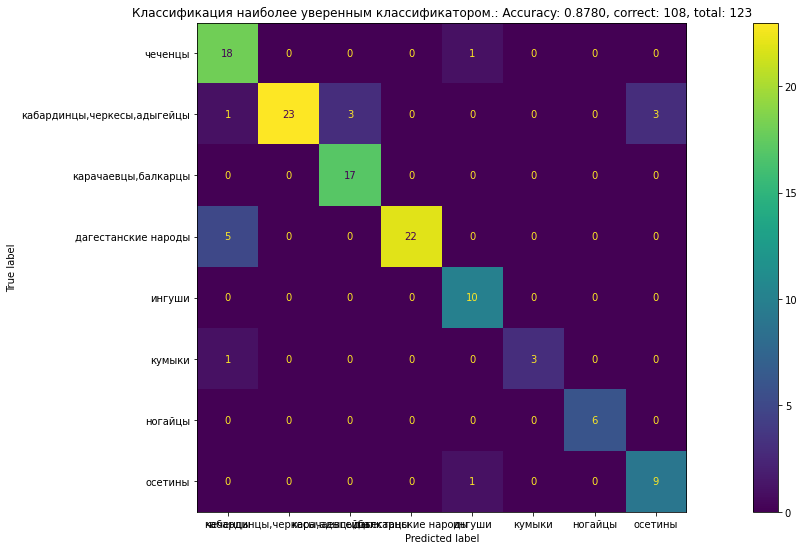

In [14]:
featureweights = {
    'IbdSumPerEdge': 0, 
    'IbdSum': 1, 
    'LongestIbd': 1, 
    'SegmentCountWMult': 0, 
    'SegmentCountPerClassize': 1, 
    'SegmentCount': 0}

#this is useful for the case where no second-best class is available, so several classifiers have infinite confidence
featurepriority = [
    "IbdSum",
    "LongestIbd",
    "SegmentCountWMult",
    "SegmentCountPerClassize",        
    "SegmentCount",    
    "IbdSumPerEdge"]

mostconfident = bh.get_most_confident_prediction(featuredict, featureweights, featurepriority)
predictedlabels = mostconfident[testnodes]
bh.show_prediction(testlabels, predictedlabels, labeldict.keys(), "Классификация наиболее уверенным классификатором.")



{'IbdSumPerEdge': 0, 'IbdSum': 0.1, 'LongestIbd': 0.1, 'SegmentCountWMult': 1, 'SegmentCountPerClassize': 0, 'SegmentCount': 0}
current: 0.8981670061099797 best 0
{'IbdSumPerEdge': 0, 'IbdSum': 0.2, 'LongestIbd': 0.1, 'SegmentCountWMult': 1, 'SegmentCountPerClassize': 0, 'SegmentCount': 0}
current: 0.8981670061099797 best 0.8981670061099797
{'IbdSumPerEdge': 0, 'IbdSum': 0.30000000000000004, 'LongestIbd': 0.1, 'SegmentCountWMult': 1, 'SegmentCountPerClassize': 0, 'SegmentCount': 0}
current: 0.8981670061099797 best 0.8981670061099797
{'IbdSumPerEdge': 0, 'IbdSum': 0.4, 'LongestIbd': 0.1, 'SegmentCountWMult': 1, 'SegmentCountPerClassize': 0, 'SegmentCount': 0}
current: 0.8981670061099797 best 0.8981670061099797
{'IbdSumPerEdge': 0, 'IbdSum': 0.5, 'LongestIbd': 0.1, 'SegmentCountWMult': 1, 'SegmentCountPerClassize': 0, 'SegmentCount': 0}
current: 0.8981670061099797 best 0.8981670061099797
{'IbdSumPerEdge': 0, 'IbdSum': 0.6, 'LongestIbd': 0.1, 'SegmentCountWMult': 1, 'SegmentCountPerClassi

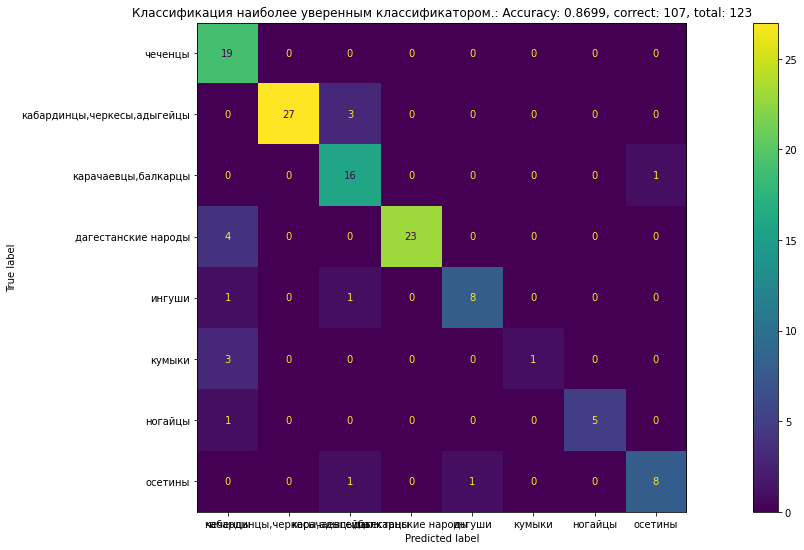

In [18]:
#search for the best parameter combination
#may take hours
featureweightrange = {
    "SegmentCount": [0],
    "SegmentCountPerClassize": [0],
    "SegmentCountWMult": [1],    
    "LongestIbd": np.arange(0.1,1.5,0.1),
    "IbdSum": np.arange(0.1,1.5,0.1),    
    "IbdSumPerEdge": [0]
}

#featureweightrange = {
#    "SegmentCount": [0],
#    "SegmentCountPerClassize": [1.38],
#    "SegmentCountWMult": [0],
#    "LongestIbd": [1],
#    "IbdSum": [0.41],
#    "IbdSumPerEdge": [0]
#}


#we will search for best weights on train nodes and then apply most confident classifier with these weights to test nodes
trainvalnodes = np.concatenate((trainnodes, valnodes))
trainvallabels = labels[trainvalnodes] 

bestweights, bestaccuracy = bh.search_best_weights(featuredict, featureweightrange, featurepriority, trainvallabels, trainvalnodes, True)
print(bestweights, bestaccuracy)

mostconfident = bh.get_most_confident_prediction(featuredict, bestweights, featurepriority)
bh.show_prediction(testlabels, mostconfident[testnodes], labeldict.keys(), "Классификация наиболее уверенным классификатором.")
#bh.show_prediction(trainlabels, mostconfident[trainnodes], labeldict.keys(), "Классификация наиболее уверенным классификатором.")

In [19]:
#repeat for new subdivision
#todo: change to f1_macro
#todo: add simple heuristics averaging
itercount = 100
totalaccr = 0
for itr in range(itercount):
    permt = bh.getrandompermutation(ncls, rng)
    #print(permt)
    trainnodeclasses, valnodeclasses, testnodeclasses = bh.dividetrainvaltest(ncls, valshare, testshare, permt)
    #here subdivision does not change translation array as we still have the same graph,
    #but will compute features only for test nodes and based on links to trainnodeclasses only

    #print("train:", trainnodeclasses)
    #print("val:", valnodeclasses)
    #print("test:", testnodeclasses)
    
    
    #when it will be neccessary to 
    #print("train|test distribution")
    #for c in trainnodeclasses:
    #    print(c, ":", trainnodeclasses[c].shape[0], ":", valnodeclasses[c].shape[0], ":", testnodeclasses[c].shape[0])

    trainnodes, valnodes, testnodes = bh.gettrainvaltestnodes(trainnodeclasses, valnodeclasses, testnodeclasses)
    #print("train nodes:", trainnodes.shape[0])
    #print("test nodes:", testnodes.shape[0])
    trainvalnodes = np.concatenate((trainnodes,valnodes))

    testlabels = labels[testnodes]
    trainvallabels = labels[trainvalnodes] 

    start = time.time()
    featuredict = bh.getfeatures(grph, grph.nodes, trainnodeclasses, labeldict, pairs, trns )
    #print(f"features collected in {time.time()-start} seconds\n")

    bestweights, bestaccuracy = bh.search_best_weights(featuredict, featureweightrange, featurepriority, trainvallabels, trainvalnodes, False)
    print("iter", itr)
    print(bestweights, bestaccuracy)
    mostconfident = bh.get_most_confident_prediction(featuredict, bestweights, featurepriority)
    accr = np.sum(testlabels == mostconfident[testnodes])/testnodes.shape[0]
    totalaccr += accr
    print(f" Accuracy: {accr:.4f}, correct: {np.sum(testlabels == mostconfident[testnodes])}, total: {testnodes.shape[0]}")
    
    #bh.show_prediction(testlabels, mostconfident[testnodes], labeldict.keys(), "Классификация наиболее уверенным классификатором.")
    #break
print("average accuracy:", totalaccr/itercount)

iter 0
{'IbdSumPerEdge': 0, 'IbdSum': 0.1, 'LongestIbd': 0.1, 'SegmentCountWMult': 1, 'SegmentCountPerClassize': 0, 'SegmentCount': 0} 0.8920570264765784
 Accuracy: 0.8699, correct: 107, total: 123
iter 1
{'IbdSumPerEdge': 0, 'IbdSum': 0.1, 'LongestIbd': 0.8, 'SegmentCountWMult': 1, 'SegmentCountPerClassize': 0, 'SegmentCount': 0} 0.8940936863543788
 Accuracy: 0.9106, correct: 112, total: 123
iter 2
{'IbdSumPerEdge': 0, 'IbdSum': 0.1, 'LongestIbd': 1.0, 'SegmentCountWMult': 1, 'SegmentCountPerClassize': 0, 'SegmentCount': 0} 0.9103869653767821
 Accuracy: 0.9187, correct: 113, total: 123
iter 3
{'IbdSumPerEdge': 0, 'IbdSum': 0.1, 'LongestIbd': 1.1, 'SegmentCountWMult': 1, 'SegmentCountPerClassize': 0, 'SegmentCount': 0} 0.9144602851323829
 Accuracy: 0.8374, correct: 103, total: 123
iter 4
{'IbdSumPerEdge': 0, 'IbdSum': 0.1, 'LongestIbd': 0.1, 'SegmentCountWMult': 1, 'SegmentCountPerClassize': 0, 'SegmentCount': 0} 0.9022403258655805
 Accuracy: 0.8943, correct: 110, total: 123
iter 5
{'I